# 1. Importing Module

In [1]:
import numpy as np
import pandas as pd
from IPython.display import clear_output
import matplotlib.pyplot as plt
import tensorflow as tf
tf.random.set_seed(123)

# 2. Load Data

In [2]:
train_data = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv')
eval_data = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv')
out_train = train_data.pop('survived')
out_eval = eval_data.pop('survived')

# 3. Data Visualization

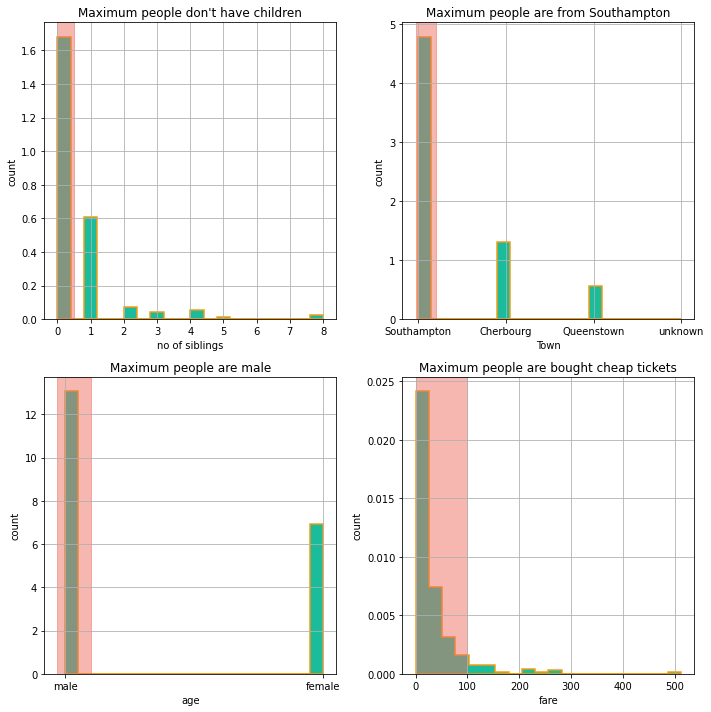

In [3]:
plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
train_data.n_siblings_spouses.hist(bins=20,facecolor = '#1ABC9C', edgecolor='#F39C12',linewidth=1.5,density=True,histtype='stepfilled')
plt.title("Maximum people don't have children")
plt.ylabel('count')
plt.xlabel('no of siblings')
plt.axvspan(0,0.5, color='#EC7063',alpha=0.5)

plt.subplot(2,2,2)
train_data.embark_town.hist(bins=20,facecolor = '#1ABC9C', edgecolor='#F39C12',linewidth=1.5,density=True,histtype='stepfilled')
plt.xlabel('Town')
plt.ylabel('count')
plt.title("Maximum people are from Southampton")
plt.axvspan(-0.03,0.2, color='#EC7063',alpha=0.5)

plt.subplot(2,2,3)
train_data.sex.hist(bins=20,facecolor = '#1ABC9C', edgecolor='#F39C12',linewidth=1.5,density=True,histtype='stepfilled')
plt.xlabel('age')
plt.ylabel('count')
plt.title("Maximum people are male")
plt.axvspan(-0.03,0.1, color='#EC7063',alpha=0.5)

plt.subplot(2,2,4)
train_data.fare.hist(bins=20,facecolor = '#1ABC9C', edgecolor='#F39C12',linewidth=1.5,density=True,histtype='stepfilled')
plt.xlabel('fare')
plt.ylabel('count')
plt.title("Maximum people are bought cheap tickets")
plt.axvspan(0,100, color='#EC7063',alpha=0.5)

plt.tight_layout()
plt.show()

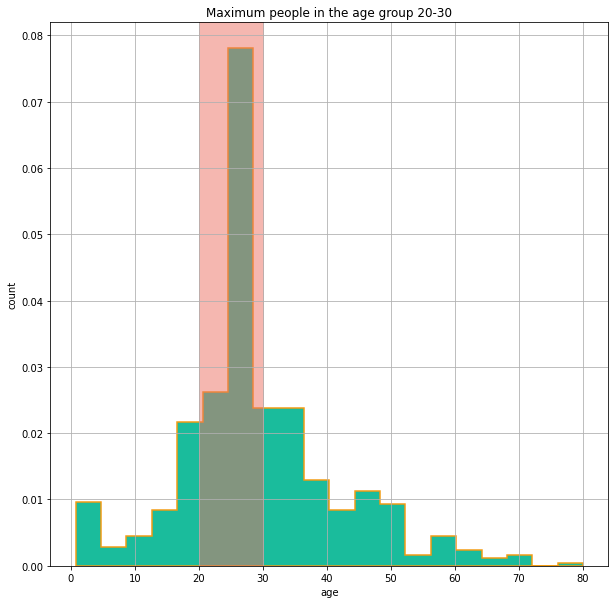

In [4]:
plt.figure(figsize=(10,10))
train_data.age.hist(bins=20,facecolor = '#1ABC9C', edgecolor='#F39C12',linewidth=1.5,density=True,histtype='stepfilled')
plt.title("Maximum people in the age group 20-30")
plt.axvspan(20,30, color='#EC7063',alpha=0.5)
plt.xlabel('age')
plt.ylabel('count')
plt.show()

# 4. Recognizing feature columns

In [5]:
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck',
                       'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']

# 5. Building Model

In [6]:
def one_hot_cat_column(feature_name, vocab):
    return tf.feature_column.indicator_column(tf.feature_column.categorical_column_with_vocabulary_list(feature_name,vocab))
feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
    vocabulary = train_data[feature_name].unique()
    feature_columns.append(one_hot_cat_column(feature_name, vocabulary))
for feature_name in NUMERIC_COLUMNS:
    feature_columns.append(tf.feature_column.numeric_column(feature_name,dtype=tf.float32))

In [7]:
example = dict(train_data.head(1))
class_fc = tf.feature_column.indicator_column(tf.feature_column.categorical_column_with_vocabulary_list('class', ('First', 'Second', 'Third')))
print('Feature value: "{}"'.format(example['class'].iloc[0]))
print('One-hot encoded: ', tf.keras.layers.DenseFeatures([class_fc])(example).numpy())

Feature value: "Third"
One-hot encoded:  [[0. 0. 1.]]


In [8]:
tf.keras.layers.DenseFeatures(feature_columns)(example).numpy()

array([[22.  ,  1.  ,  0.  ,  1.  ,  0.  ,  0.  ,  1.  ,  0.  ,  0.  ,
         0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  ,  0.  ,  0.  ,
         7.25,  1.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,
         0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  ]], dtype=float32)

In [9]:
NUM_EXAMPLES = len(out_train)
def make_input_fn(X, y, n_epochs=None, shuffle=True):
    def input_fn():
        dataset = tf.data.Dataset.from_tensor_slices((dict(X), y))
        if shuffle:
            dataset = dataset.shuffle(NUM_EXAMPLES)
        dataset = dataset.repeat(n_epochs)
        dataset = dataset.batch(NUM_EXAMPLES)
        return dataset
    return input_fn
train_input_fn = make_input_fn(train_data, out_train)
eval_input_fn = make_input_fn(eval_data, out_eval, shuffle=False, n_epochs=1)

# 6. Training and Evaluating the Model

In [10]:
linear_est = tf.estimator.LinearClassifier(feature_columns)
linear_est.train(train_input_fn, max_steps=100)
result = linear_est.evaluate(eval_input_fn)
clear_output()
print(pd.Series(result))

accuracy                  0.765152
accuracy_baseline         0.625000
auc                       0.832844
auc_precision_recall      0.789631
average_loss              0.478908
label/mean                0.375000
loss                      0.478908
precision                 0.703297
prediction/mean           0.350790
recall                    0.646465
global_step             100.000000
dtype: float64


In [11]:
n_batches = 1
est = tf.estimator.BoostedTreesClassifier(feature_columns,n_batches_per_layer=n_batches)
est.train(train_input_fn, max_steps=100)
result = est.evaluate(eval_input_fn)
clear_output()
print(pd.Series(result))

accuracy                  0.833333
accuracy_baseline         0.625000
auc                       0.874931
auc_precision_recall      0.859920
average_loss              0.405004
label/mean                0.375000
loss                      0.405004
precision                 0.795699
prediction/mean           0.383333
recall                    0.747475
global_step             100.000000
dtype: float64


# 7. Final Predictions Visualization

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\Hp\AppData\Local\Temp\tmplem890uy\model.ckpt-100
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


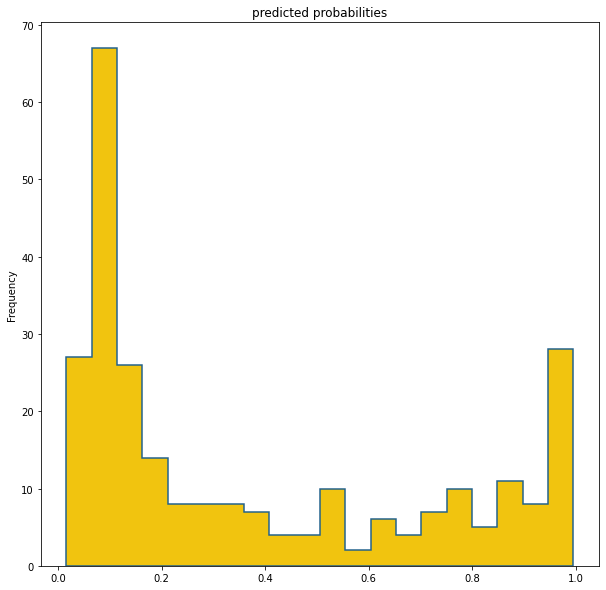

In [12]:
plt.figure(figsize=(10,10))
pred_dicts = list(est.predict(eval_input_fn))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])
probs.plot(kind='hist', bins=20, title='predicted probabilities',facecolor = '#F1C40F', edgecolor='#21618C',linewidth=1.5,histtype='stepfilled')
plt.show()

In [13]:
# 8. Receiver operating characteristic (ROC)

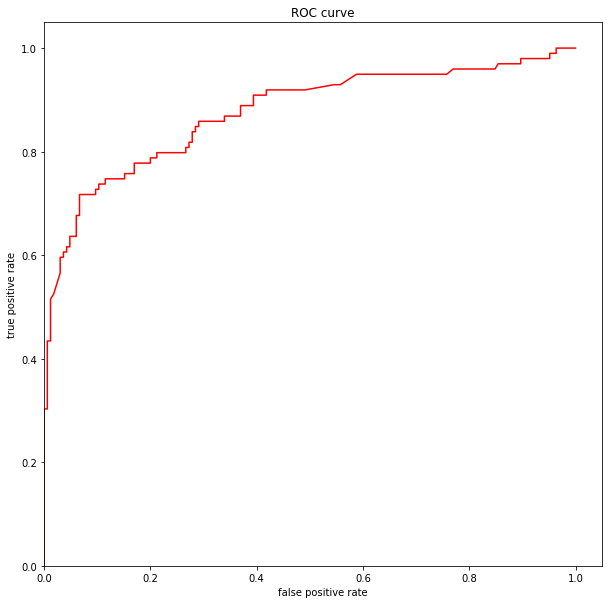

In [14]:
from sklearn.metrics import roc_curve
plt.figure(figsize=(10,10))
fpr, tpr, _ = roc_curve(out_eval, probs)
plt.plot(fpr, tpr,color="red")
plt.title('ROC curve')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.xlim(0,)
plt.ylim(0,)
plt.show()